## HW 10 CLUSTERING BUSINESS

In [69]:
import json
import urllib2
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import glob, os

import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [57]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

### 1. Get & prep data 

In [58]:
#download census data for businesses by ZIP code

#%%bash

#for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

#for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [59]:
# download NYC zip codes shape file

url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
nyc_zipcodes = json.load(request)
nyc_zip = []
for department in nyc_zipcodes['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))

In [60]:
import zipfile #i am not giving it a name cause i intend to use it only once

os.chdir(".")

fname = "zbp00totals.zip"
zf = zipfile.ZipFile(fname)
biz = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
biz = biz.rename(columns={'zip': 'ZIP', 'est': 'EST'})
biz_data = biz[['ZIP', 'EST']]
biz_data = biz_data[(biz_data.ZIP.astype(str).isin(nyc_zip))]
biz_data['YEAR'] = 2000

for fname in glob.glob("*.zip"):
    if fname == "zbp00totals.zip":
        continue
    zf = zipfile.ZipFile(fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df = df.rename(columns={'zip': 'ZIP', 'est': 'EST'})
    df = df[['ZIP', 'EST']]
    df = df[(df.ZIP.astype(str).isin(nyc_zip))]
    if int(fname[3:5]) > 93:
        df['YEAR'] = int('19' + fname[3:5])
    else:
        df['YEAR'] = int('20' + fname[3:5])
    biz_data = biz_data.append(df, ignore_index=True)

In [61]:
biz_data_est = pd.DataFrame(np.nan,index=sorted(unique(biz_data.ZIP)),columns=range(1994,2014))
biz_data_est.loc[biz_data_est.index==10001][1994]

10001   NaN
Name: 1994, dtype: float64

In [62]:
for z in biz_data_est.index:
    for y in biz_data_est.columns:
        biz_est = biz_data[(biz_data.ZIP == int(z)) & (biz_data.YEAR == y)]
        if len(biz_est) != 0:
            biz_data_est.loc[z, y] = int(biz_est.EST.values[0])

In [63]:
biz_data_est.head()

1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  2005  \
10001  6999  7088  7075  7154  7254  7233  7317  7188  7141  7084  7370  7312   
10002  1784  1819  1919  2049  2003  2085  2277  2543  2269  2402  2551  2682   
10003  3256  3377  3417  3535  3649  3659  3683  3602  3616  3704  3776  3867   
10004  1115  1124  1133  1173  1176  1233  1294  1247  1253  1252  1283  1260   
10005  1076  1109  1216  1227  1270  1242  1287  1249  1244  1200  1226  1214   

       2006  2007  2008  2009  2010  2011  2012  2013  
10001  7415  7549  7472  7305  7241  7227  7235  7273  
10002  2686  2685  2691  2775  2872  2912  2954  2988  
10003  3909  4049  4071  4099  4113  4159  4214  4277  
10004  1311  1370  1376  1379  1398  1404  1442  1479  
10005  1259  1273  1291  1274  1266  1301  1273  1296

### 2. Whitening data

In [64]:
result = biz_data_est.copy()
for i in range(len(biz_data_est)):
    result.iloc[i] = (result.iloc[i]-np.mean(result.iloc[i]))/np.std(result.iloc[i])

### 3. K Means Clustering

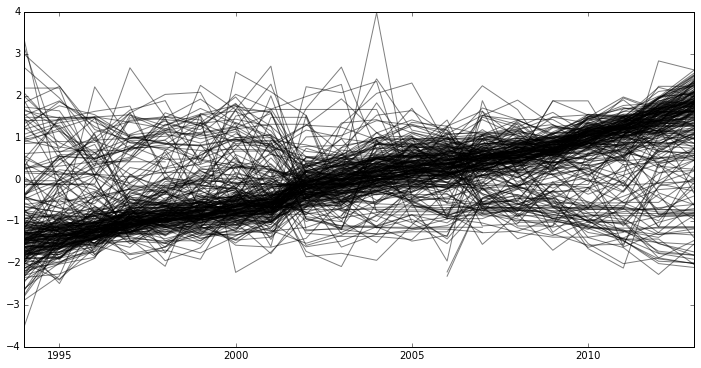

In [65]:
plt.figure(figsize=(12,6))
plt.xlim(1994,2013)
for i in range(len(result)):
    plt.plot(result.iloc[i].index, result.iloc[i], 'k', alpha=0.5)

In [66]:
result.head()

1994      1995      1996      1997      1998      1999      2000  \
10001 -1.831632 -1.173250 -1.269418 -0.685012  0.054742 -0.100607  0.520787   
10002 -1.722813 -1.631907 -1.372173 -1.034519 -1.153997 -0.941015 -0.442326   
10003 -1.872528 -1.457250 -1.319968 -0.914985 -0.523731 -0.489411 -0.407041   
10004 -1.608897 -1.523770 -1.438643 -1.060302 -1.031926 -0.492790  0.084181   
10005 -2.885957 -2.304004 -0.417066 -0.223082  0.535220  0.041442  0.835014   

           2001      2002      2003      2004      2005      2006      2007  \
10001 -0.433496 -0.781180 -1.202840  0.912857  0.483799  1.245746  2.237017   
10002  0.248565 -0.463105 -0.117659  0.269344  0.609595  0.619984  0.617387   
10003 -0.685038 -0.636989 -0.334968 -0.087861  0.224456  0.368602  0.849090   
10004 -0.360370 -0.303619 -0.313078 -0.019863 -0.237409  0.244976  0.803030   
10005  0.164887  0.076712 -0.699225 -0.240717 -0.452336  0.341236  0.588125   

           2008      2009      2010      2011      2012      2013  
10001  1.667406  0.432016 -0.041426 -0.144992 -0.085811  0.195295  
10002  0.632971  0.851147  1.103089  1.206982  1.316071  1.404380  
10003  0.924595  1.020693  1.068741  1.226616  1.415379  1.631598  
10004  0.859781  0.888157  1.067869  1.124620  1.484044  1.834010  
10005  0.905554  0.605760  0.464681  1.081903  0.588125  0.993729

In [67]:
Result = result.dropna()

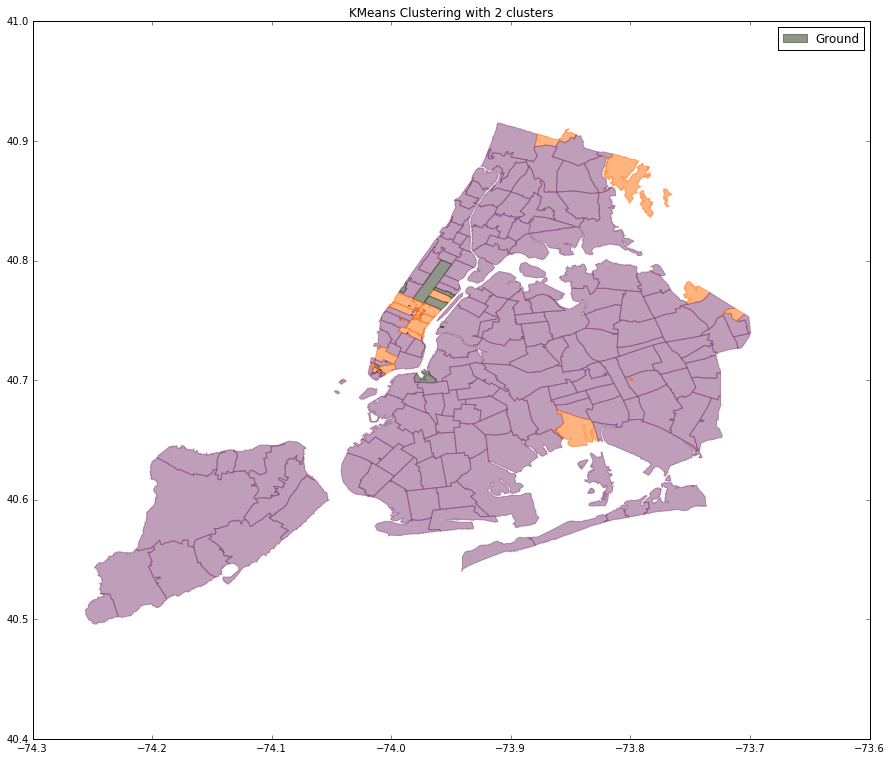

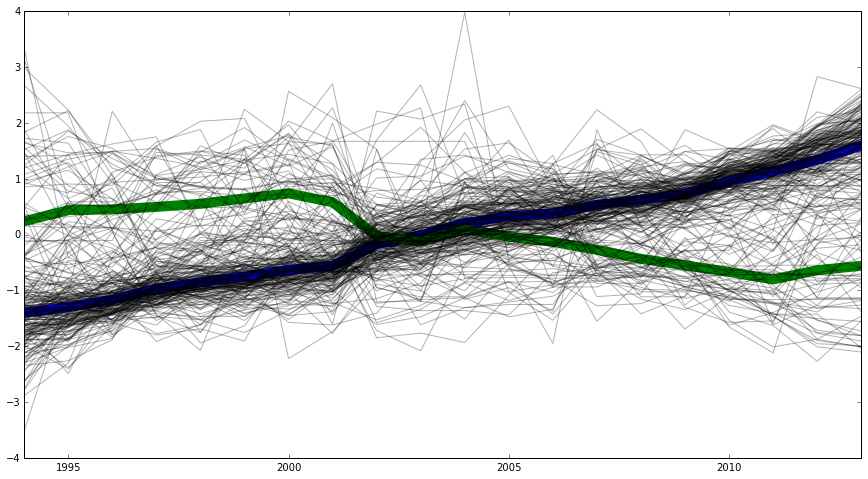

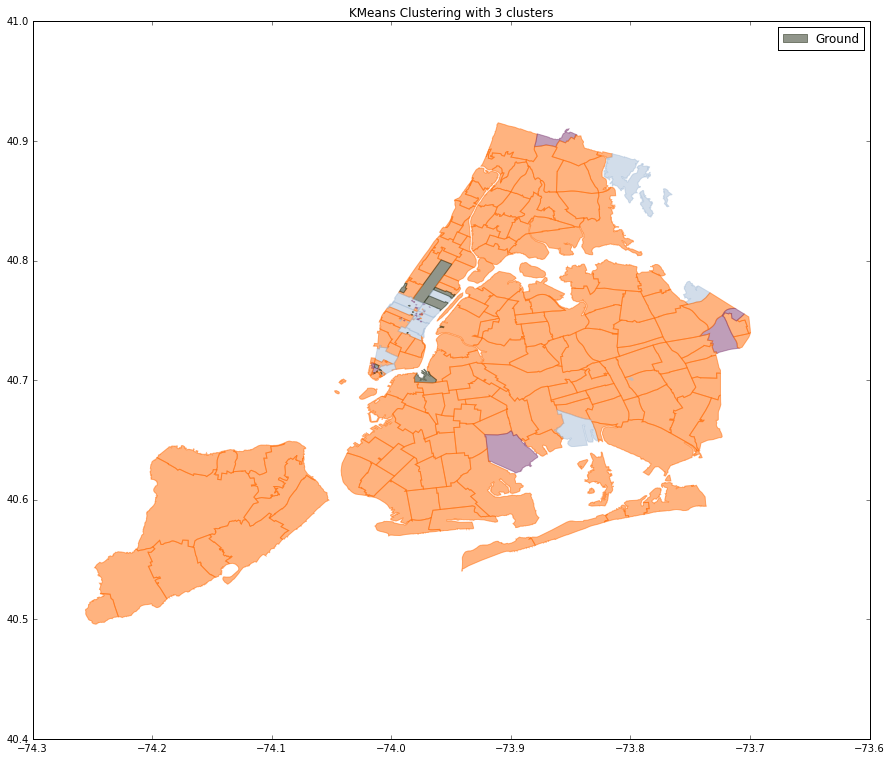

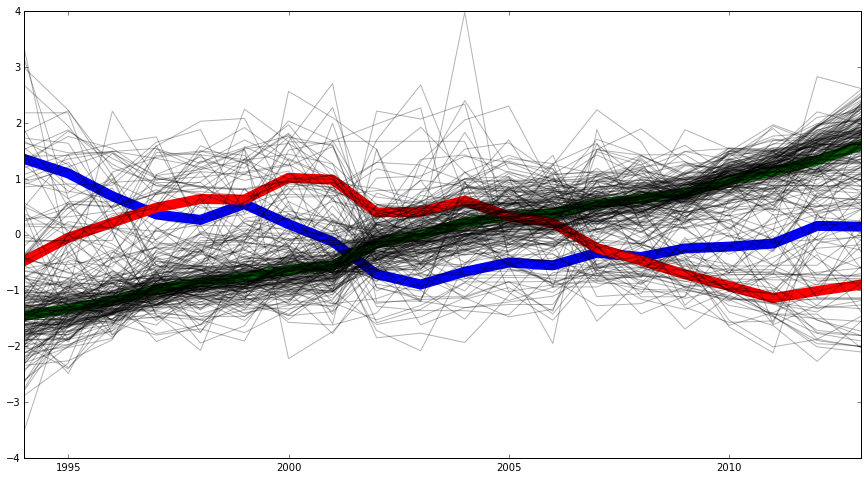

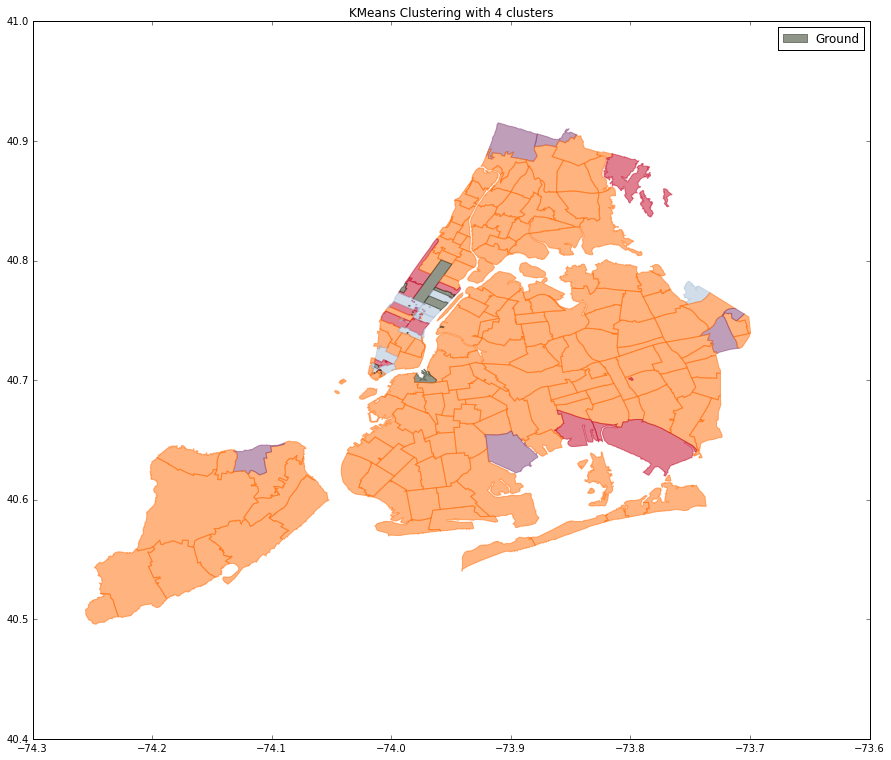

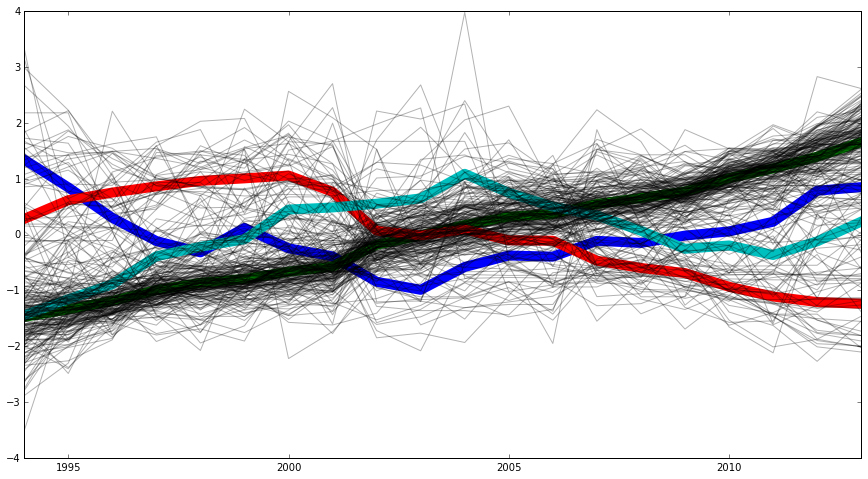

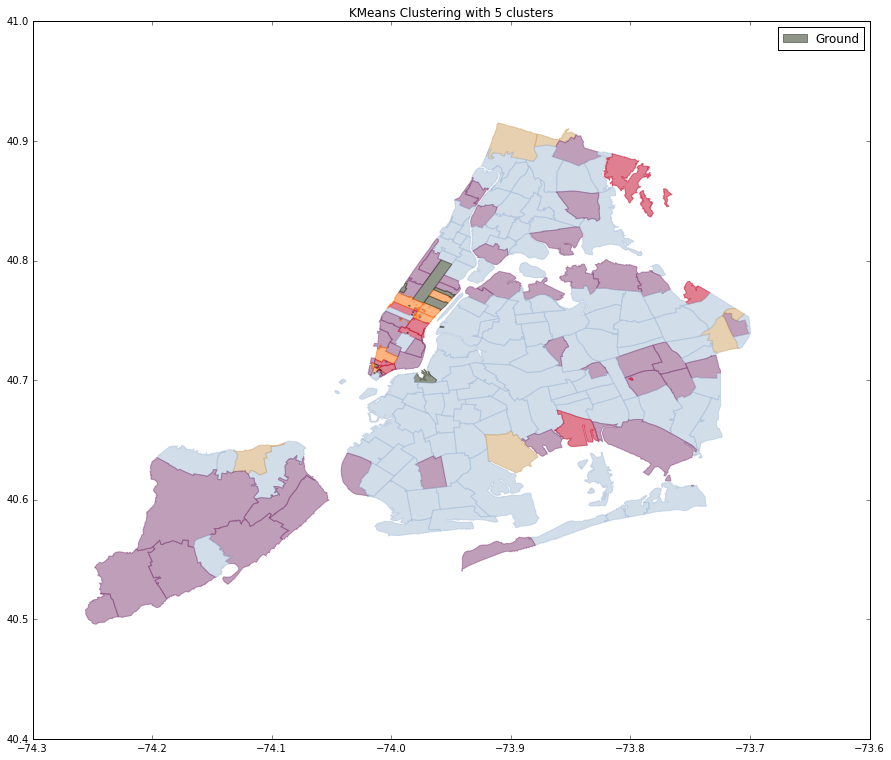

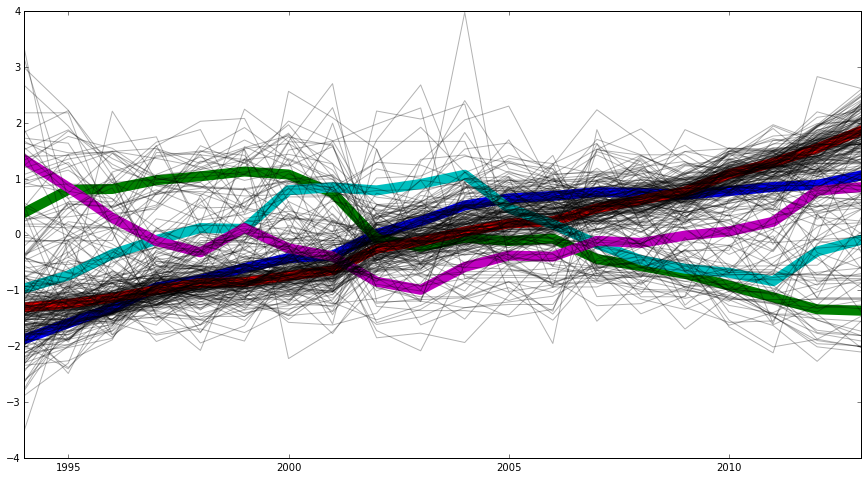

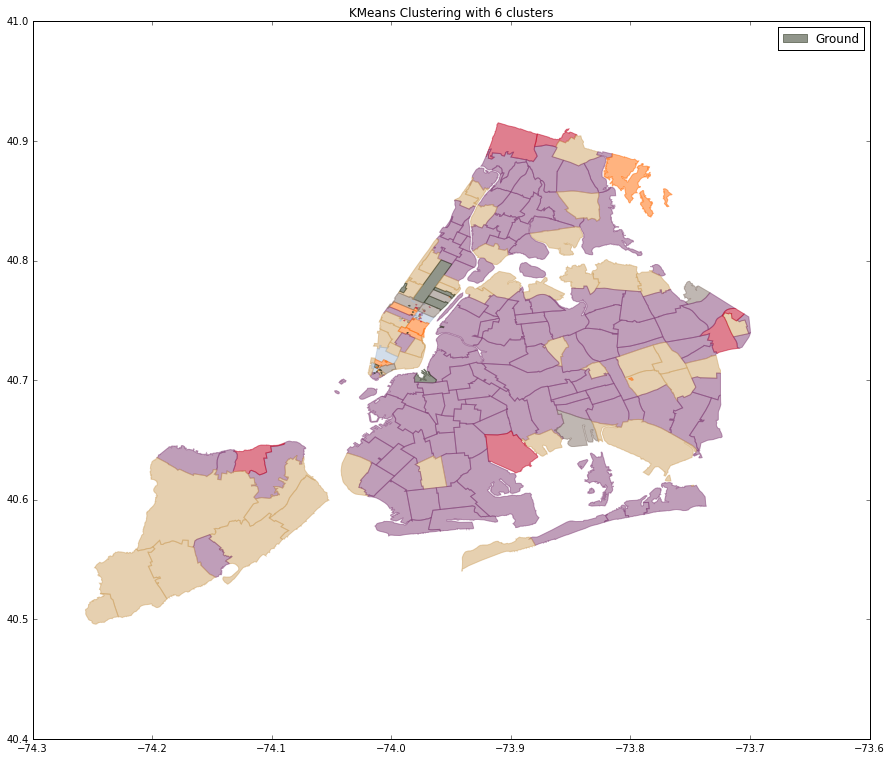

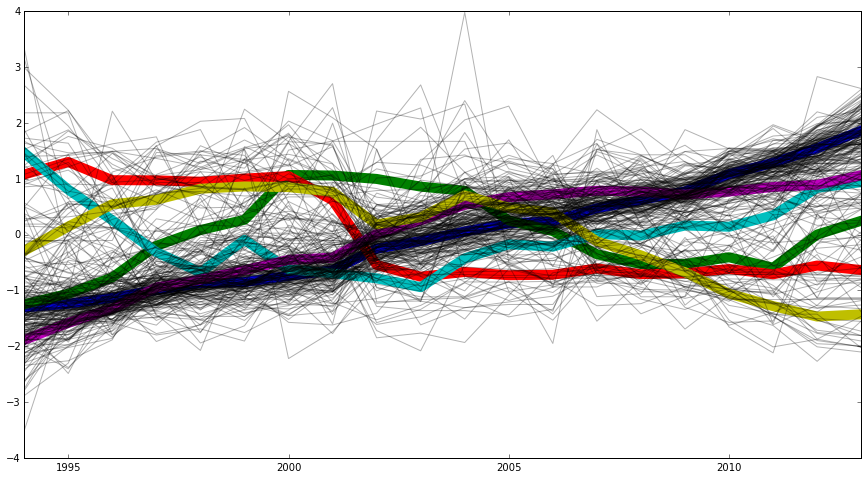

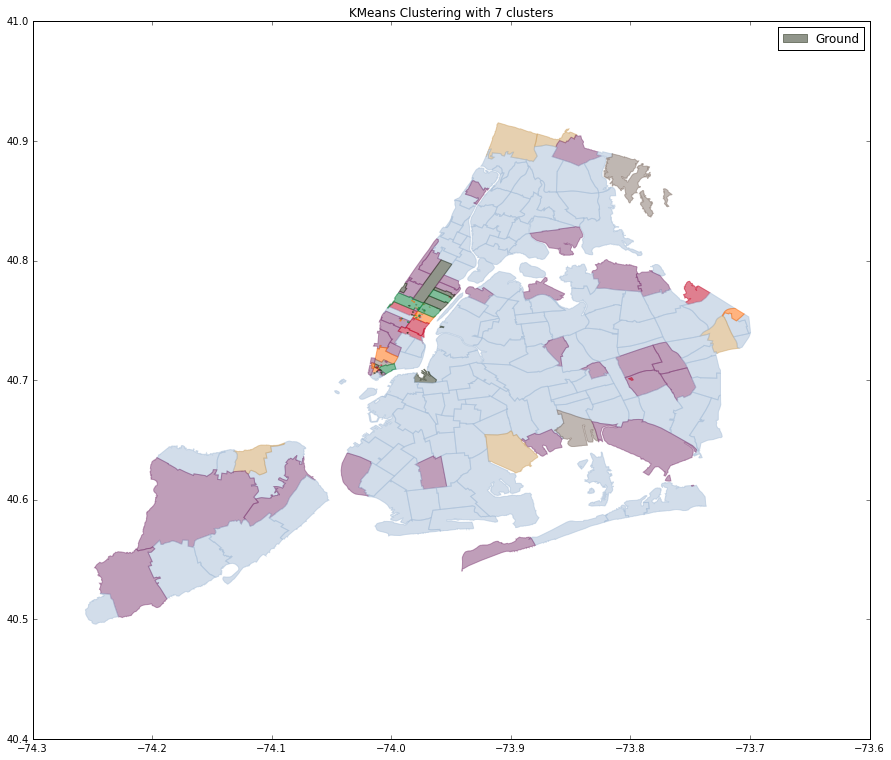

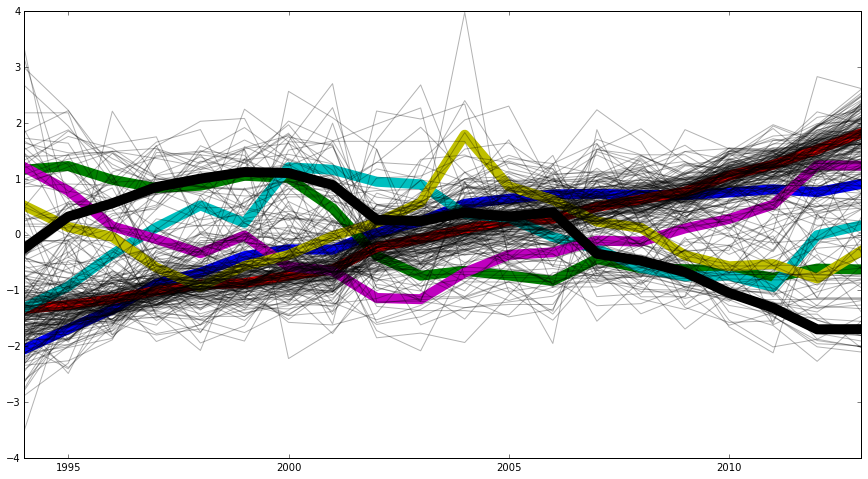

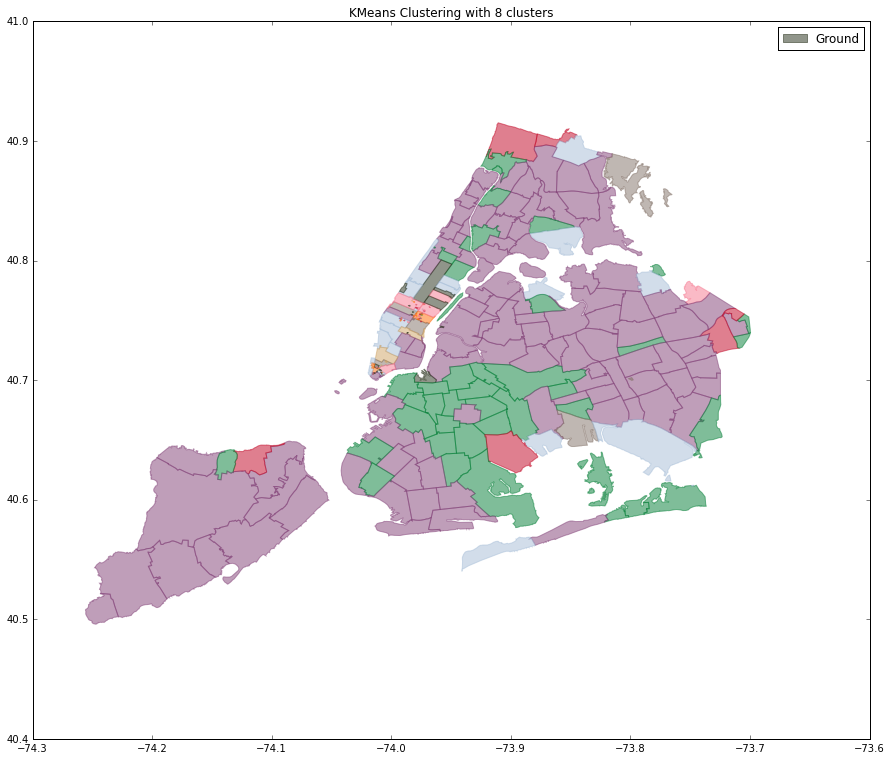

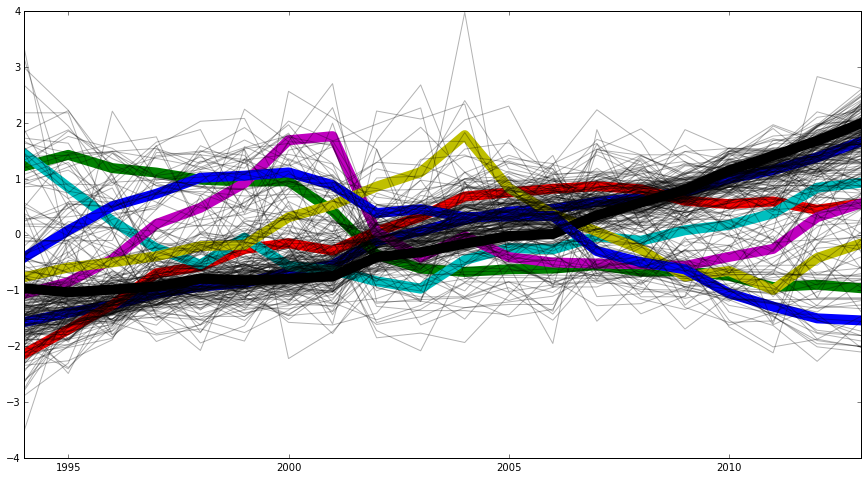

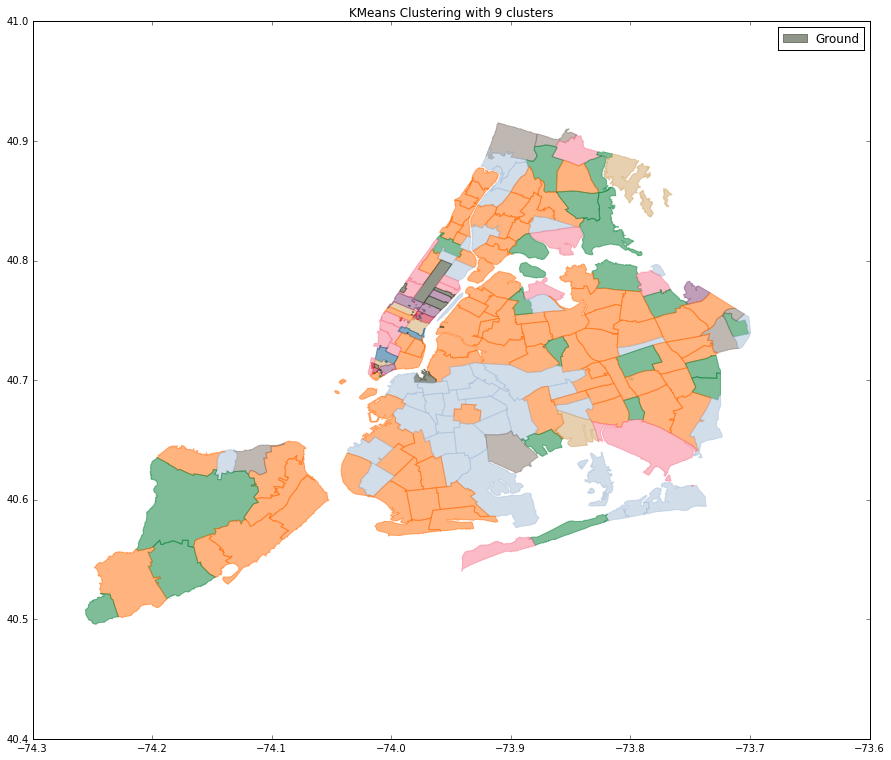

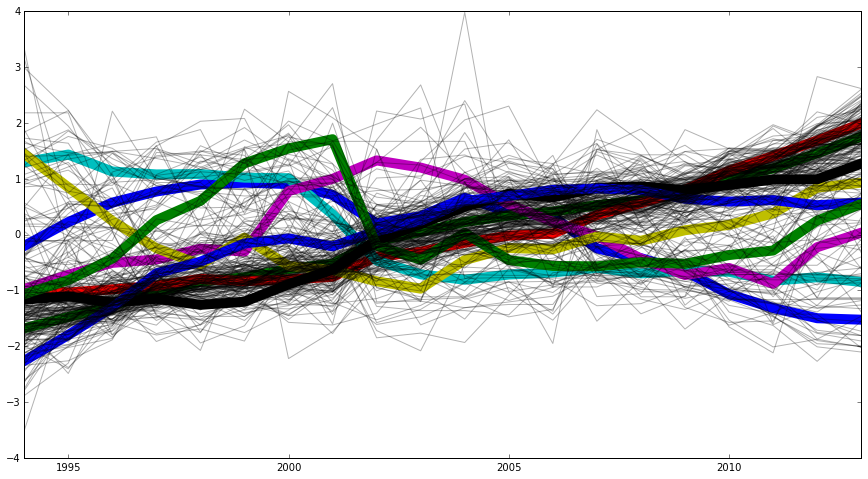

In [71]:
silhouette_scores = {}
for nc in range(2,10):   
    #Clustering
    kmeans = sklearn.cluster.KMeans(n_clusters=nc)
    kmeans.fit(Result.values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    #Silhouette score
    silhouette_avg = silhouette_score(Result.values, kmeans.labels_)
    silhouette_scores[nc] = silhouette_avg
    
    #Plotting 
    cluster = labels
    clustered_zips = pd.DataFrame({'zip':Result.index, 'cluster':cluster})
    fig = plt.figure(figsize=(15,15)) 
    for i in nyc_zipcodes['features']:
        poly = i['geometry']
        postcode = int(i['properties']['postalCode'])
        ax = fig.gca()
        GREEN = kelly_colors_hex[19]
        if postcode in list(Result.index):
            color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
            ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
        else:
            ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
    ax.axis('scaled')
    import matplotlib.patches as mpatches

    ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
    plt.legend(handles=[ground],loc='best')
    plt.title('KMeans Clustering with %s clusters'%(nc))
    plt.figure(figsize=(15,8))
    plt.xlim(1994,2013)
    for i in range(len(centers)):
        plt.plot(range(1994,2014),centers[i],linewidth=10) 
    for i in range(len(Result)):
        plt.plot(Result.iloc[i].index, Result.iloc[i],'k',alpha=0.3)

### 4.  DBScan Cluster

In [74]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [75]:
# Calculate distance matrix
dist_mat = pd.DataFrame(np.zeros(shape=(len(Result),len(Result))))
for i in range(len(Result)):
    for j in range(len(Result)):
        dist_mat.iloc[i][j] = euclid_dist(Result.iloc[i],Result.iloc[j])

In [76]:
from sklearn.cluster import DBSCAN
db = DBSCAN(metric="precomputed",eps=2).fit(dist_mat)

In [77]:
db_labels = (db.labels_).astype(int)
num_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print('Number of clusters: %d' % num_clusters)

Number of clusters: 3


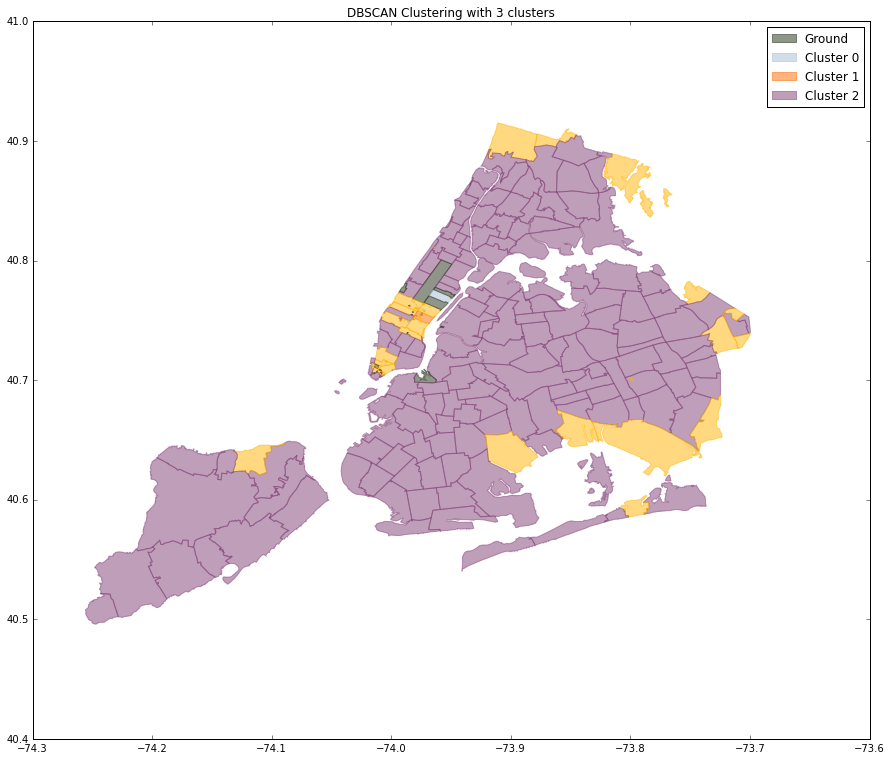

In [82]:
cluster = db_labels
clustered_zips = pd.DataFrame({'zip':Result.index, 'cluster':cluster})
fig = plt.figure(figsize=(15,15)) 
for i in nyc_zipcodes['features']:
    poly = i['geometry']
    postcode = int(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(Result.index):
        color = kelly_colors_hex[int(clustered_zips[clustered_zips['zip']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
patch0 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 0')
patch1 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 1')
patch2 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 2')
plt.legend(handles=[ground,patch0,patch1,patch2],loc='best')
plt.title('DBSCAN Clustering with %s clusters'%(num_clusters))

Based on visual inspection, it seems that DBSCAN and KMeans clustering provide very similar results. 
